<a href="https://colab.research.google.com/github/JaredLevi18/Image-generator./blob/main/image%20editor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
 !pip install -q --upgrade transformers==4.25.1 diffusers ftfy accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 27.4 MB/s eta 0:00:00


In [2]:
from base64 import b64encode
import numpy as np
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel, DDIMScheduler, DDIMInverseScheduler
from huggingface_hub import notebook_login

# for video display
from IPython.display import HTML
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as T
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# supress some warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# set device
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == device: os.environ['PYTORCH_ENABLE_MPS_FALLLBACK'] = "1"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [3]:
# load the autoencoder model which will be used to decode the latents (4x64x64) into image space
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# load the tokenizer and texr encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# the UNet model
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# the noise scheduler
scheduler = LMSDiscreteScheduler(beta_schedule="scaled_linear", num_train_timesteps=1000)
DDIM_scheduler = DDIMScheduler(beta_schedule="scaled_linear", num_train_timesteps=1000)
inverse_scheduler = DDIMInverseScheduler(num_train_timesteps=1000, beta_schedule='scaled_linear')

# set everything to the gpu
vae = vae.to(device)
encoder = encoder.to(device)
unet = unet.to(device);

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vae/config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

torch.Size([2, 77, 768])


  0%|          | 0/30 [00:00<?, ?it/s]

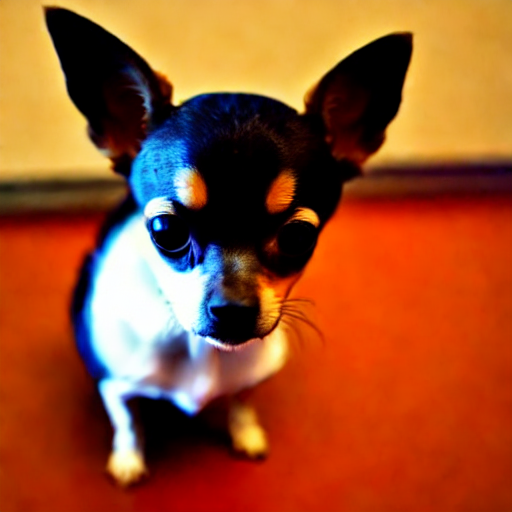

In [4]:
# settings
prompt = ["a small chihuahua"]
# width and height values are the standard for stable diffusion
height = 512
width = 512
num_inference_steps = 30    # number of denoising steps
guidance_scale = 8       # scale for classifier-free guidance
generator = torch.manual_seed(32)  # used to create the inital latent noise
batch_size = 1


# prepare text
input_text = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  embeddings = encoder(input_text.input_ids.to(device))[0]
max_length = input_text.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = encoder(uncond_input.input_ids.to(device))[0]
embeddings = torch.cat([uncond_embeddings, embeddings])
print(embeddings.shape)
# prepare scheduler
def set_timesteps(scheduler, num_inference_steps):
  scheduler.set_timesteps(num_inference_steps)
  scheduler.timesteps = scheduler.timesteps.to(torch.long)
set_timesteps(scheduler, num_inference_steps)

# prepare latents

latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator
)
latents = latents.to(device)
latents = latents * scheduler.init_noise_sigma # scaling

# diffusion loop
with autocast("cuda"):
  for i,t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes
    latent_model_input = torch.cat([latents] * 2)
    #sigma = scheduler.sigmas[i]
    #latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # predic the noise residual
    with torch.no_grad():
      noise_pred = unet(latent_model_input, t, encoder_hidden_states=embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    #latents = scheduler.step(noise_pred, i, latents)["prev_sample"]
    latents = scheduler.step(noise_pred, t, latents).prev_sample

# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents
with torch.no_grad():
  image1 = vae.decode(latents).sample

# display
image = (image1 / 2 + 0.5).clamp(0,1)
image = image.detach().cpu().permute(0,2,3,1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

Image editing.

In [5]:
# here we take sample latents and apply mask in sample process
def sample_edit(self, x, steps=20, t_start=None, t_end=None, order=3, skip_type='time_uniform', method='singlestep',
                lower_order_final=True, denoise_to_zero=False, solver_type='dpm_solver',
                atol=0.0078, rtol=0.05, record_list=None, mask=None):
  t_0 = 1. / self.noise_schedule_total_N if t_end is None else t_end
  if t_start is None: t_T = self.noise_schedule.T
  else: t_T = t_start

  if record_list is None: assert len(record_list) == steps
  if method == 'adaptive':
    with torch.no_grad():
      x = self.dpm_solver_adaptive(x, order=order, t_T=t_T, t_0=t_0, atol=atol, rtol=rtol, solver_type=solver_type)
  elif method == 'multistep':
    assert steps >= order
    timesteps = self.get_time_steps(skip_type=skip_type, t_T=t_T, t_0=t_0, N=steps, device=device)
    assert timesteps.shape[0] - 1 == steps
    with torch.no_grad():
      vec_t = timesteps[0].expand((x.shape[0]))
      model_prev_list = [self.model_fn(x, vec_t)]
      t_prev_list = [vec_t]
      # Init the first order values by lower order multistep DPM-Solver
      for init_order in range(1, order):
        vec_t = timesteps[init_order].expand(x.shape[0])
        x = self.miltistep_dpm_solver_update(x, model_prev_list, t_prev_list, vec_t, init_order, solver_type=solver_type)
        if mask is not None and record_list is not None:
          x = record_list[init_order - 1].to(device) * (1. - mask) + x * mask
        model_prev_list.append(self.model_fn(x, vec_t))
        t_prev_list.append(vec_t)

      # Compute the remaining values by order-th order multistep DPM-Solver
      for step in range(order, steps + 1):
        vec_t = timesteps[step].expand(x.shape[0])
        if lower_order_final and steps < 15: step_order = min(order, steps+1)
        else: step_order = order
        x = self.multistep_dpm_solver_update(x, model_prev_list, t_prev_list, vec_t, step_order, solver_type=solver_type)
        if mask is not None and record_list is not None: x = record_list[step - 1].to(device) * (1. - mask) + x * mask
        for i in range(order - 1):
          t_prev_list[i] = t_prev_list[i + 1]
          model_prev_list[i] = model_prev_list[i + 1]
        t_prev_list[-1] = vec_t
        # we don't need to evaluate the final model value
        if step < steps: model_prev_list[-1] = self.model_fn(c, vec_t)

  elif method in ['singlestep', 'singlestep_fixed']:
    if method == 'singlestep':
      timesteps_outer, orders = self.get_orders_and_timesteps_for_singlestep_solver(steps=steps, order=order, skip_type=skip_type, t_T=t_T, t_0=t_0, device=device)
    elif method == 'singlestep_fixed':
      k = steps // order
      orders = [order, ] * k
      timesteps_outer = self.get_time_steps(skip_type=skip_type, t_T=t_T, t_0=t_0, N=k, deivce=device)
    for i, order in enumerate(orders):
      t_T_inner, t_0_inner = timesteps_outer[i], timesteps_outer[i + 1]
      timesteps_inner = self.get_time_steps(skip_type=skip_type, t_T=t_T_inner.item(), t_0=t_0_inner.item(), N=order, device=device)
      lamda_inner = self.noise_schedule.marginal_lamda(timesteps_inner)
      vec_s, vec_t = t_T_inner.tile(x.shape[0]), t_0_inner.tile(x.shape[0])
      h = lamda_inner[-1] - lamda_inner[0]
      r1 = None if order <= 1 else (lamda_inner[1] - lamda_inner[0])/h
      r2 = None if order <= 2 else (lamda_inner[2] - lamda_inner[0])/h
      x = self.singlestep_dpm_solver_update(x, vec_s, vec_t, order, solver_type=solver_type, r1=r1, r2=r2)

  if denoise_to_zero:
    x = self.denoise_to_zero_fn(x, torch.ones((x.shape[0],)).to(device) * t_0)

  return x

def sample(self, x, steps=20, t_start=None, t_end=None, order=3, skip_type='time_uniform', method='singlestep', lower_order_final=True, denoise_to_zero=False, solver_type='dpm_solver',
           atol=0.0078, rtol=0.05, record_process=False, record_list=None):
  t_0 = 1. / self.noise_schedule_total_N if t_end is None else t_end
  t_T = self.noise_schedule.T if t_start is None else t_start
  if method == 'adaptative':
    with torch.no_grad():
      x = self.dpm_solver_adaptive(x, order=order, t_T=t_T, t_0=t_0, atol=atol, rtol=rtol, solver_type=solver_type)
  elif method == 'multistep':
    assert steps >= order
    timesteps = self.get_time_steps(skip_type=skip_type, t_T=t_T, t_0=t_0, N=steps, device=device)
    assert timesteps.shape[0] - 1 == steps
    with torch.no_grad():
      vec_T = timesteps[0].expand((x.shape[0]))
      model_prev_list = [self.model_fn(x, vec_t)]
      t_prev_list = [vec_t]
      # Init the first order values by lower order multistep DPM_Solver
      for init_order in range(1, order):
        vec_t = timesteps[init_order].expand(x.shape[0])
        x = self.multistep_dpm_solver_update(x, model_prev_list, t_prev_list, vec_t, init_order, solver_type=solver_type)
        if record_process:
          record_list.append(x.cpu())
        model_prev_list.append(self.model_fn(x, vec_t))
        t_prev_list.append(vec_t)
      # Compute the remaining values by order-th order the miltistep DPM-Solver
      for step in range(order, step+1):
        vec_t = timesteps[step].expand(x.shape[0])
        if lower_order_final and steps < 15:
          step_order = min(order, steps + 1 - step)
        else: step_order = order
        x = self.multistep_dom_solver_update(x, model_prev_list, t_prev_list, vec_t, step_order, solver_type=solver_type)
        if record_precess:
          record_list.append(x.cpu())
        for i in range(oder-1):
          t_prev_list[i] = t_prev_list[i+1]
          model_prev_list[i] = model_prev_list[i+1]
        t_prev_list[-1] = vec_t
        # We do not need to evaluate the final value.
        if step < steps:
          model_prev_list[-1] = self.model_fn(x, vec_t)
  elif method in ['singlestep', 'singlestep_fixed']:
    if method == 'singlestep':
      timestep_outer, orders = self.get_orders_and_timesteps_for_single_solver(steps=steps, order=order, skip_type=skip_type, t_T=t_T, t_0=t_0, device=device)
    elif method == 'singlestep_fixed':
      k = steps // order
      orders = [order, ] * k
      timesteps_outer = self.get_time_steps(skip_type=skip_type, t_T=t_T, t_0=t_0, N=k, device=device)
    for i, order in enumerate(orders):
      t_T_inner, t_0_inner = timesteps_outer[i], timesteps_outer[i+1]
      timesteps_inner = self.get_time_steps(skip_type=skip_type, t_T=t_T_inner.item(), t_0=t_0_inner.item(), N=order, device=device)
      lamda_inner = self.noise_schedule.marginal_lambda(timesteps_inner)
      vec_s, vec_t = t_T_inner.tile(x.shape[0]), t_0_inner.tile(x.shape[0])
      h = lamda_inner[-1] - lamda_inner[0]
      r1 = None if order <= 1 else (lamda_inner[1] - lamda_inner[0]) / h
      r2 = None if order <= 2 else (lamda_inner[2] - lamda_inner[0]) / h
      x = self.singlestep_dpm_solver_update(x, vec_s, vec_t, order,r1, r2, solver_type=solver_type)
  if denoise_to_zero:
    x = self.denoise_to_zero_fn(x, torch.ones((x.shape[0],)).to(device) * t_0)
  return x

In [34]:
def image_to_latent(image):
  with torch.no_grad():
    latent = vae.encode(T.ToTensor()(image).unsqueeze(0).to(device)*2-1)
  return 0.18215 * latent.latent_dist.sample()

def latents_to_image(latents):
    # bath of latents -> list of images
    latents = (1 / 0.18215) * latents
    with torch.no_grad():
        image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images

def repeat_tensor(x, n, dim=0):
    dims = len(x.shape) * [1]
    dims[dim] = n
    return x.repeat(dims)

def set_timesteps(scheduler, num_inference_steps):
  scheduler.set_timesteps(num_inference_steps)
  scheduler.timesteps = scheduler.timesteps.to(torch.long)
set_timesteps(scheduler, num_inference_steps)

def get_mask(src, dst, init_latent, n, num_inference_steps, clamp_rate):
    '''
    The map value will be clamped to map.mean() * clamp_rate, then values will be scaled into 0-1, then turn into binary(split at 0.5, same like in the paper).
    So if a map value is larger than map.mean() * clamp_rate * 0.5 will be come 1, otherwise 0.
    Therefore the larger the clamp_rate is, less pixels will be encoded to 1.
    '''

    scheduler.sigma = torch.linspace(0.0, 1.0, 32)
    strength = 0.8
    # figuring initial time step based on strength
    init_timestep = int(num_inference_steps * strength)
    timesteps = scheduler.timesteps[-init_timestep]
    timesteps = torch.tensor([timesteps], device='cuda')

    # Adding noise to the latents
    noise = torch.randn_like(init_latent) # random noise  init_latent = encoded (latents without noise)
    t = scheduler.timesteps[num_inference_steps - 1]
    t = t.unsqueeze(dim=0)
    noised = scheduler.add_noise(init_latent, noise, scheduler.timesteps[t])

    # computing the timesteps to start the diffusion loop
    t_start = max(num_inference_steps - init_timestep, 0)
    timesteps = scheduler.timesteps[t_start:].to('cuda')

    diff = {}
    for g in range(10):

      for i,t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # we need to scale the latents to match the variance
        inp = scheduler.scale_model_input(torch.cat([noised] * 2), t)

        with torch.no_grad():
          # predict the noise residual using U-Net, onece with the reference text and once with the query_Q
          noise_pred_uncond, noise_pred_text = unet(inp, t, encoder_hidden_states=src).sample.chunk(2)
          noise_pred_uncond2, noise_pred_text2 = unet(inp, t, encoder_hidden_states=dst).sample.chunk(2)

        # perform guidance
        pred_src = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)
        pred_dst = noise_pred_uncond2 + guidance_scale * (noise_pred_text2 - noise_pred_uncond2)

        # Conditioning the latents
        #   print('noised shape', noised.shape)
        #   print('pred_dst shape complete', pred_dst.shape)
        #   print('pred_dst shape', pred_dst.view(pred_dst.shape[-1], -1).shape)
        while True:
          try:
            pred_src = scheduler.step(pred_src.view(-1, pred_src.shape[-1]), t, noised.view(-1, noised.shape[-1])).prev_sample
            pred_dst = scheduler.step(pred_dst.view(-1, pred_src.shape[-1]), t, noised.view(-1, noised.shape[-1])).prev_sample
          except: break # continue

        # getting the latent representation to output an array of 4x64x64
        orig_noise =  pred_src.detach().cpu()
        query_noise = pred_dst.detach().cpu()
        print(orig_noise)
        print(query_noise)

        # taking the difference
        diff[i] =  (np.array(orig_noise) - np.array(query_noise))

    # create a mask placeholder
    mask = np.zeros_like(diff[0])

    # Taking an average of 10 iterations
    for idx in range(10):
      mask += np.abs(diff[idx])

    mask = mask.mean(0) # Averaging multiple channels
    mask = (mask - mask.mean()) / np.std(mask) # Normalizing

    # def to_binary(pix):
    #   if pix > 0.5: return 1
    #   else: return 0

    # mask = mask.cpu().apply_(to_binary).to(device)

    # Binarizing and returning the mask object
    return (mask > 0).astype("uint8")

def see_mask(mask):
  plt.imshow(np.array(pil_images[0]), cmap='gray', interpolation='none')
  plt.imshow(
      Image.fromarray(mask).resize((512, 512)),
      cmap='cividis',
      alpha=0.5*(np.array(Image.fromarray(mask*255).resize(512,512))>0)
  )

In [7]:
# image --> latent
encoded = image_to_latent(pil_images[0])
set_timesteps(scheduler, num_inference_steps)

# adding noise to the input image(latents).
start_step = 10
noise = torch.randn_like(encoded) # random noise
encoded_and_noised = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
encoded_and_noised = encoded_and_noised.float() # noisy latent

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

(64, 64)


TypeError: Cannot handle this data type: (1, 1, 64), |u1

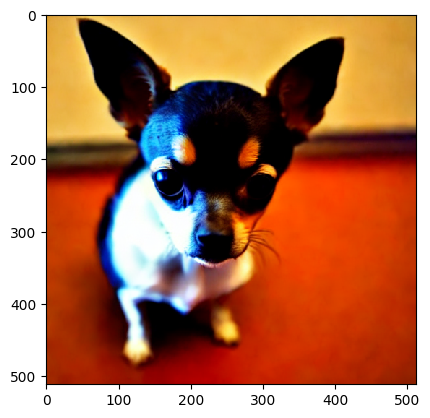

In [35]:
pil_images[0] # init_image
reference = ['a small chihuahua'] # prompt describing the original image
query_q = ['a small pitbull'] # prompt describing the desired image
encode_ratio: float = 0.6
num_inference_steps = 30 # ddim_ratio
guidance_scale = 8
seed = 32
scale: float = 7.5 # classifier free guidance
encoded = image_to_latent(pil_images[0]) # latents of the original image

with torch.no_grad():
  with autocast(device):
    uc = None
    # prepare thext
    if scale != 1.0:
      uc = tokenizer([''], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

    src1 = tokenizer(reference ,padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
      embeddings = encoder(src1.input_ids.to(device))[0]
    max_length = src1.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
      uncond_embeddings = encoder(uncond_input.input_ids.to(device))[0]
    src = torch.cat([uncond_embeddings, embeddings])

    dst1 = tokenizer(query_q, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
      embeddings2 = encoder(dst1.input_ids.to(device))[0]
    max_length2 = dst1.input_ids.shape[-1]
    with torch.no_grad():
      uncond_embeddings2 = encoder(uncond_input.input_ids.to(device))[0]
    dst = torch.cat([uncond_embeddings2, embeddings2])

    # # prepare latents
    # latents = torch.randn(
    #     (batch_size, unet.config.in_channels, height // 8, width // 8),
    #     generator=generator
    # )
    # latents = latents.to(device)
    # init_latents = latents * scheduler.init_noise_sigma

    # Step 1: compute mask
    # FIX THE MASK PART
    mask = get_mask(src=src, dst=dst, init_latent=encoded, n=1, num_inference_steps=num_inference_steps, clamp_rate=3.0)
    print(mask[0].shape)
    # plt.imshow(mask[0].detach().cpu().numpy())
    # plt.show()
    see_mask(mask[0])

    # Step 2: encoding with DDIM

    # step 3: Decode with mask-wise correction


In [ ]:
(scheduler.timesteps - torch.tensor(1)).shape

In [ ]:
# estimating noise conditioned to query Q.
encoded_and_noised = encoded_and_noised.to(device)
encoded_and_noised = encoded_and_noised * scheduler.init_noise_sigma

promt = ['A small pitbull'] # query_q
# prepare text
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
  text_embeddings = encoder(text_input.input_ids.to(device))[0]
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = encoder(uncond_input.input_ids.to(device))[0]
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# denoising loop
with autocast("cuda"):
  for i,t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([encoded_and_noised] * 2)
        sigma = scheduler.sigmas[i]
        # Scale the latents (preconditioning):
        # latent_model_input = latent_model_input / ((sigma**2 + 1) ** 0.5) # Diffusers 0.3 and below
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        # latents = scheduler.step(noise_pred, i, latents)["prev_sample"] # Diffusers 0.3 and below
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        print(latens.shape)

latents_to_image(latents)[0]

In [ ]:
latents.shape